In [ ]:
import numpy as np
import pickle

In [ ]:
    def relu(x):
        if np.isscalar(x):
            result = np.maximum(x, 0)
        else:
            x = np.stack((x , np.zeros(x.shape)), axis = -1)
            result = np.max(x, axis = -1)
        return result

In [ ]:
relu(np.array([-1,1]))

array([0., 1.])

In [ ]:
    
    def softmax(x):
        numerator = np.exp(x-np.max(x))
        return numerator/np.sum(numerator)

In [ ]:
softmax(np.array([1,2]))

array([0.26894142, 0.73105858])

In [ ]:
np.max(np.array([1,2]).reshape(1,-1))

2

In [ ]:
softmax(np.array([[1,2],[2,3],[4,5]]))

array([[0.01129825, 0.03071182],
       [0.03071182, 0.08348338],
       [0.22693136, 0.61686338]])

In [ ]:
np.max(np.array([[1,2],[2,3],[4,5]]))

5

In [ ]:
import random

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
class MLPClassifier(object):
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def relu(self,x):
#         if np.isscalar(x):
#             result = np.maximum(x, 0)
#         else:
#             x = np.stack((x , np.zeros(x.shape)), axis = -1)
#             result = np.max(x, axis = -1)
        result = x*(x>=0)
        return result
    
    def tanh(self,x):
        numerator = (np.exp(x)-np.exp(-x))
        denominator = (np.exp(x)+np.exp(-x))
        return numerator/denominator
    
    def softmax(self,x):
        x -=   np.max(x, axis=1).reshape((-1, 1))
        x = np.exp(x)
        x /= np.sum(x, axis=1).reshape((-1, 1))
        return x
    
    def derivative_tanh(self,x):
        return (1-np.square(self.tanh(x)))
    
    def derivative_relu(self,x):
        return 1* (x>0)
            
    
    def derivative_sigmoid(self,x):
        return self.sigmoid(x) * (1-self.sigmoid(x))
    
    
    def activation(self,x,activation_function):
        if activation_function == 'relu':
            return self.relu(x)
        elif activation_function=='sigmoid':
            return self.sigmoid(x)
        elif activation_function=='tanh':
            return self.tanh(x)
        elif activation_function=="softmax":
            return self.softmax(x)
        else:
            return self.softmax(x)
        
    def get_params(self,weight_init):
        weights = []
        bias = []
        np.random.seed(100)
        if weight_init == "random":
            for index in range(len(self.layers)-1):
                weights.append(np.random.randn(self.layers[index],self.layers[index+1]))
                bias.append(np.zeros((1,self.layers[index+1])))
        if weight_init == "xavier":
            for index in range(len(self.layers)-1):
                weights.append(np.random.randn(self.layers[index],self.layers[index+1]) * np.sqrt(1/(self.layers[index]+self.layers[index+1])))
                bias.append(np.zeros((1,self.layers[index+1])))
        if weight_init == "he":
            for index in range(len(self.layers)-1):
                weights.append(np.random.randn(self.layers[index],self.layers[index+1]) * np.sqrt(2/(self.layers[index]+self.layers[index+1])))
                bias.append(np.zeros((1,self.layers[index+1])))
        biases = bias
        
        return weights,biases
                
        
    def activation_derivatives(self,x,activation_function):
        if activation_function == "sigmoid":
            return self.derivative_sigmoid(x)
        elif activation_function == "tanh":
            return self.derivative_tanh(x)
        elif activation_function == "relu":
            return self.derivative_relu(x)
        
    def __init__(self,layers, learning_rate=1e-5, activation_function='relu',optimizer='gradient_descent', Weight_init="random",regularization="l2",batch_size=64,num_epochs=3000,dropout=0.2,**kwargs):
        self.layers = layers
        self.number_of_layers = len(layers)
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.regularization=regularization
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.dropout = dropout
        self.weight_init = Weight_init
        self.val_X = None
        self.val_y = None
        
    def forward_propagate(self, X,y):
        activations=[X]
        affine_transform_values = [X]
        for index in range(len(self.weights)):
            z = np.dot(activations[-1],self.weights[index]) + self.biases[index]
            affine_transform_values.append(z)
            if index ==len(self.layers)-2:
                activation_value = self.activation(z,'softmax')

            else:
                activation_value = self.activation(z,self.activation_function)
            activations.append(activation_value)
        return affine_transform_values,activations
    
    def cross_entropy_loss(self,output,label):
        return (-np.sum(label * np.log(output+1e-9)))/label.shape[0]
    def backpropagate(self,y,j,affine_transforms,outputs):
        dloss_dz = outputs[-1][j] - y
        delta_b = [np.zeros(b.shape) for b in self.biases]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta_b[-1] = dloss_dz
        # 50,10000 *  10000,10
#         delta_w[-1] = np.dot(outputs[-2].T,dloss_dz) 
        derivatives = dloss_dz
        for index in range(len(self.layers)-2,0,-1):

            derivatives = np.dot(derivatives, self.weights[index].T) * self.activation_derivatives(affine_transforms[index][j],self.activation_function)
            delta_b[index-1] = derivatives
        delta_w = [np.dot(output[j].reshape(1,-1).T,delta.reshape(1,-1)) for output,delta in zip(outputs,delta_b)]
        return delta_w,delta_b

    
    #credit this code was taken and modified from common open source blog codes
    def plot_confusion_matrix(self,y_true, y_pred, class_names,normalize=False,title=None,cmap=plt.cm.Blues):

        title = 'Confusion matrix'
        print("*******",y_true,y_pred)
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data
        classes = class_names
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix")

        #print(cm)

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax      
                                                                                                           
                                                                                                           
                                                                                                           
                                                                                                           
    def plot_graphs(self,indices,train_losses,val_losses):
        %matplotlib notebook
        plt.plot(indices,train_losses,label='trainloss')
        plt.plot(range(0,len(val_losses)),val_losses,label='val loss')
        plt.xlabel('Number of epochs')
        plt.legend()
        plt.show()
    def compute_confusion_matrix(self,labels,pred):    
        class_names=np.arange(0,10,1)
        self.plot_confusion_matrix(np.array(labels), np.array(pred),class_names)

        print('accuracy',accuracy_score(labels, pred))
    def compute_val_loss_plot_metrics(self,stop_counter,train_loss,val_loss,epoch,val_losses):
        val_X = self.val_X
        val_y = self.val_y
        val_batches_X = [self.val_X[index : index+self.batch_size] for index in range(0, len(self.val_X), self.batch_size)]
        val_batches_y = [self.val_y[index : index+self.batch_size]for index in range(0, len(self.val_y), self.batch_size)]
        all_preds = []
        for val_batch in zip(val_batches_X, val_batches_y):
            val_outputs = []
            for validation_x,validation_y in zip(val_batch[0],val_batch[1]):
                validation_x = validation_x.reshape(1,784)
                va_affine_transforms, va_outputs = self.forward_propagate(validation_x,validation_y)
                val_outputs.append(va_outputs[-1])
                all_preds.append(va_outputs[-1])
            val_loss+=self.cross_entropy_loss(np.array(val_outputs).squeeze(),val_batch[1])
        print("epoch: ",epoch,"  epoch validation loss", (val_loss/len(val_batches_X)))
        val_losses.append(val_loss/len(val_batches_X))
        return val_losses,all_preds


    # val set is passed only to compute loss. Not used in learning the model
    def fit(self,X,y):
        weights,biases = self.get_params(self.weight_init)
        self.weights = weights
        self.biases=biases
        val_X = self.val_X
        val_y = self.val_y
        indices = np.arange(X.shape[0], dtype=int)
        random.seed(0)
        train_losses = []
        val_losses = []
        stop_counter = 0
        for epoch in range(self.num_epochs):
            loss = 0
            val_loss=0
            random.shuffle(indices)
            
            
            batches_X = [X[indices[index : index+self.batch_size]] for index in range(0, len(X), self.batch_size)]
            batches_y = [y[indices[index : index+self.batch_size]] for index in range(0, len(y), self.batch_size)]
            #full batch gradient descent or mini_batch
            for batch in zip(batches_X,batches_y):
                running_delta_w = []
                running_delta_b = []
                output_batch = []
#                 for x,y_batch in zip(batch[0],batch[1]):
#                 x = x.reshape(1,784)
                affine_transforms, outputs = self.forward_propagate(batch[0],batch[1])
                output_batch=outputs[-1]
                for index,(x,y_batch) in enumerate(zip(batch[0],batch[1])):
#                     print("index",index,x.shape,y.shape)
#                     x = x.reshape(1,784)
#                     affine_transforms, outputs = self.forward_propagate(x,y_batch)
                    delta_w,delta_b = self.backpropagate(y_batch,index,affine_transforms,outputs)
                    if (len(running_delta_w)==0 and len(running_delta_b)==0):
                        running_delta_w = delta_w
                        running_delta_b=delta_b
                    else:
                        running_delta_w = [(sum_w+delta) for sum_w,delta in zip(running_delta_w,delta_w)] 
                        running_delta_b = [sum_b+delta for sum_b,delta in zip(running_delta_b,delta_b)] 
#                 running_delta_w=[delta_w/X.shape[0] for delta_w in running_delta_w]
                running_delta_w = [delta/batch[0].shape[0] for delta in running_delta_w]
                running_delta_b = [delta_b/batch[0].shape[0] for delta_b in running_delta_b]
                if self.optimizer == 'gradient_descent':
                    self.weights = [w - (self.learning_rate*dw) for dw,w in zip(running_delta_w,self.weights)]
                    self.biases = [b - (self.learning_rate*db) for db,b in zip(running_delta_b,self.biases)]
                loss+=self.cross_entropy_loss(output_batch,batch[1])
            print("epoch: ",epoch,"  epoch training loss", (loss/len(batches_X)))
            train_losses.append(loss/len(batches_X))
            val_losses,all_preds = self.compute_val_loss_plot_metrics(stop_counter,train_losses,val_loss,epoch,val_losses)
            if len(val_losses)>2 and val_losses[-1] > val_losses[-2]:
                stop_counter+=1
            else:
                stop_counter=0
            index=[i for i in range(0,len(train_losses)) ]
            if stop_counter >10:
                print("val loss not improving for more than 10 epochs. So stopping.....")
                break
            validation_preds = np.concatenate(all_preds,axis=0).squeeze()
            validation_preds = np.argmax(validation_preds,axis=1)
            print("validation accuracy",accuracy_score(np.argmax(val_y,axis=1),validation_preds))
            index=[i for i in range(0,len(train_losses)) ]
        self.plot_graphs(index,train_losses,val_losses)
        validation_preds = np.concatenate(all_preds,axis=0).squeeze()
        validation_preds = np.argmax(validation_preds,axis=1)
        self.compute_confusion_matrix(np.argmax(val_y,axis=1),validation_preds)
        import joblib
        print("saving weights.....")
        joblib.dump(self.weights, 'weight_tanh_he_64_lr_001')
        joblib.dump(self.biases, 'bias_tanh_he_64_lr_001')

        fpr = dict()
        tpr=dict()
        predictions = np.concatenate(all_preds,axis=0).squeeze()
        plt.figure()
        for i in range(10):
            fpr[i],tpr[i],_ =  roc_curve(val_y[:,i],predictions[:,i])
        for i in range(10):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0}'
                                   ''.format(i))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
            
#                 print("losss",output_batch[0:10],y[indices[:10]],self.cross_entropy_loss(np.array(output_batch).squeeze(),y_batch),y.shape)
        
        
    def predict(self,X):
        preds = []
        for x in X:
            transforms,outputs = self.forward_propagate(x,None)
            preds.append(outputs[-1])
            
        return np.argmax(np.array(preds).squeeze(),axis=1)
            
            
    
    
    def predict_proba(self,X):
        preds = []
        for x in X:
            transforms,outputs = self.forward_propagate(x,None)
            preds.append(outputs[-1])
        return np.array(preds).squeeze()

                
        
        
    def score(self,X,y):
        val_outputs =[]
        for test_X,test_y  in zip(X,y):
                    test_X = test_X.reshape(1,784)
                    va_affine_transforms, va_outputs = self.forward_propagate(test_X,test_y)
                    val_outputs.append(va_outputs[-1])
        test_out = np.array(val_outputs).squeeze()
        test_out = np.argmax(test_out,axis=1)
        return np.sum(y==test_out)/len(y)



In [ ]:
np.sum(np.array([[1,2],[2,3]]),axis=1)

array([3, 5])

In [ ]:
from scipy.special import xlogy

xlogy(np.array([[0,1],[0,1]]), np.array([[0,1],[1,1]])).shape

(2, 2)

In [ ]:
val = [np.array([[1,2],[3,4]]), np.array([[2,3],[5,6]])]
np.concatenate(val,axis=0)

array([[1, 2],
       [3, 4],
       [2, 3],
       [5, 6]])

In [ ]:
for i,(x,y) in enumerate(zip(np.array([1,2,1,3]),np.array([3,4,4,5]))):
    print(i,x,y)

0 1 3
1 2 4
2 1 4
3 3 5


In [ ]:
# np.sum(train_Y==np.argmax(train_Y_one_hot,axis=1))/len(train_Y)

In [ ]:
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(verbose=True,activation='logistic', solver='sgd',max_iter=300, nesterovs_momentum=False, learning_rate_init=0.1,batch_size=64).fit(train_X.reshape(-1,784)/255.0,train_Y_one_hot)

In [ ]:
def load_train_test_data():
    with open("train_set.pkl","rb") as train:    
        train_data = pickle.load(train)
        train.close()
    with open("val_set.pkl","rb") as val:    
        val_data = pickle.load(val)
        val.close()
    return train_data,val_data

In [ ]:
from PIL import Image
train_data,val_data = load_train_test_data()
for index,row in train_data.iterrows():
    train_data.at[index,'Image'] = np.array(row['Image'])
for index,row in val_data.iterrows():
    val_data.at[index,'Image'] = np.array(row['Image'])

In [ ]:
train_X = np.stack(train_data['Image'].values)
train_Y = train_data['Labels'].values
val_X = np.stack(val_data['Image'].values)
val_y = val_data['Labels'].values

In [ ]:
def encode_labels(y, num_labels):
        onehot = np.zeros((y.shape[0],num_labels))
        for i in range(y.shape[0]):
            onehot[i,y[i]] = 1.0
        return onehot

In [ ]:
train_Y_one_hot = encode_labels(train_Y,10)
val_Y_one_hot = encode_labels(val_y,10)

## relu activation batch size 64 (300 epochs) Xavier initialization

In [ ]:
classifier = MLPClassifier([784,128,64,10],batch_size=64,learning_rate=0.001,num_epochs=300,activation_function='relu',Weight_init='xavier')

In [ ]:
classifier.val_X = val_X.reshape(-1,784)/255.0
classifier.val_y = val_Y_one_hot
import time
start =time.time()
classifier.fit((train_X.reshape(-1,784)/255.0),train_Y_one_hot)
print(time.time()-start)

epoch:  0   epoch training loss 2.2837410132792937
epoch:  0   epoch validation loss 2.2657287659986225
validation accuracy 0.198
epoch:  1   epoch training loss 2.2593019423599547
epoch:  1   epoch validation loss 2.2438127118577365
validation accuracy 0.2275
epoch:  2   epoch training loss 2.2336451479475077
epoch:  2   epoch validation loss 2.220293247749036
validation accuracy 0.2655
epoch:  3   epoch training loss 2.2061820985859066
epoch:  3   epoch validation loss 2.1947637239190945
validation accuracy 0.305
epoch:  4   epoch training loss 2.1771465566126147
epoch:  4   epoch validation loss 2.1671865187790265
validation accuracy 0.3395
epoch:  5   epoch training loss 2.144724627061214
epoch:  5   epoch validation loss 2.1370901609388073
validation accuracy 0.3815
epoch:  6   epoch training loss 2.1110721258798533
epoch:  6   epoch validation loss 2.104705079012617
validation accuracy 0.411
epoch:  7   epoch training loss 2.074164133438764
epoch:  7   epoch validation loss 2.069

<IPython.core.display.Javascript object>

******* [7 2 1 ... 0 0 0] [7 2 1 ... 0 0 0]
confusion matrix


<IPython.core.display.Javascript object>

accuracy 0.8935
saving weights.....


<IPython.core.display.Javascript object>

2068.5781383514404


In [ ]:
import joblib
classifier.weights = joblib.load('weight_relu_xavier_64_lr_0001')
classifier.biases = joblib.load('bias_relu_xavier_64_lr_0001')

In [ ]:
classifier.predict(val_X.reshape(-1,784))

array([7, 2, 1, ..., 0, 0, 0])

In [ ]:
accuracy_score(classifier.predict(val_X.reshape(-1,784)),val_y)

0.898

In [ ]:
classifier.predict_proba(val_X.reshape(-1,784))

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
classifier.score(val_X.reshape(-1,784),val_y)

0.898

## relu activation batch size 64 (300 epochs) He initialization

In [ ]:
classifier = MLPClassifier([784,128,64,10],batch_size=64,learning_rate=0.001,num_epochs=300,activation_function='relu',Weight_init='he')

epoch:  0   epoch training loss 2.258037079299105
epoch:  0   epoch validation loss 2.199785078242738
validation accuracy 0.2135
epoch:  1   epoch training loss 2.168176490714182
epoch:  1   epoch validation loss 2.1243873051614046
validation accuracy 0.266
epoch:  2   epoch training loss 2.080647189216311
epoch:  2   epoch validation loss 2.047879465945317
validation accuracy 0.35
epoch:  3   epoch training loss 1.992130841906223
epoch:  3   epoch validation loss 1.9691548705608166
validation accuracy 0.411
epoch:  4   epoch training loss 1.9037945851520464
epoch:  4   epoch validation loss 1.8894631483770379
validation accuracy 0.469
epoch:  5   epoch training loss 1.8128678885082283
epoch:  5   epoch validation loss 1.808989218380251
validation accuracy 0.5115
epoch:  6   epoch training loss 1.7248958295203747
epoch:  6   epoch validation loss 1.729423301765581
validation accuracy 0.548
epoch:  7   epoch training loss 1.636891796275565
epoch:  7   epoch validation loss 1.65079228427

epoch:  62   epoch validation loss 0.5027395233266436
validation accuracy 0.8625
epoch:  63   epoch training loss 0.3862519177446624
epoch:  63   epoch validation loss 0.49991182990212657
validation accuracy 0.863
epoch:  64   epoch training loss 0.3809374916765516
epoch:  64   epoch validation loss 0.4966686597697793
validation accuracy 0.8625
epoch:  65   epoch training loss 0.3780882501903614
epoch:  65   epoch validation loss 0.49382608898073005
validation accuracy 0.864
epoch:  66   epoch training loss 0.37384170297496877
epoch:  66   epoch validation loss 0.49120710309522436
validation accuracy 0.8645
epoch:  67   epoch training loss 0.3714148911425046
epoch:  67   epoch validation loss 0.48860510589618805
validation accuracy 0.8645
epoch:  68   epoch training loss 0.36884840091960885
epoch:  68   epoch validation loss 0.4861658543258923
validation accuracy 0.865
epoch:  69   epoch training loss 0.36690468242808993
epoch:  69   epoch validation loss 0.4837954860824959
validation 

epoch:  124   epoch training loss 0.2862467500610812
epoch:  124   epoch validation loss 0.4067024504849521
validation accuracy 0.877
epoch:  125   epoch training loss 0.28372197177397523
epoch:  125   epoch validation loss 0.4059649927263327
validation accuracy 0.8785
epoch:  126   epoch training loss 0.28371743490631335
epoch:  126   epoch validation loss 0.4049829538317785
validation accuracy 0.8785
epoch:  127   epoch training loss 0.282083127256836
epoch:  127   epoch validation loss 0.4040721671287912
validation accuracy 0.878
epoch:  128   epoch training loss 0.28331717594627565
epoch:  128   epoch validation loss 0.40339101446720094
validation accuracy 0.8785
epoch:  129   epoch training loss 0.2803758321139325
epoch:  129   epoch validation loss 0.4022635031306974
validation accuracy 0.8775
epoch:  130   epoch training loss 0.284150400770247
epoch:  130   epoch validation loss 0.40150612383204715
validation accuracy 0.878
epoch:  131   epoch training loss 0.278862744601506
epo

epoch:  185   epoch training loss 0.23882035623621992
epoch:  185   epoch validation loss 0.36703336849893375
validation accuracy 0.8895
epoch:  186   epoch training loss 0.23934216415212697
epoch:  186   epoch validation loss 0.3668134498504238
validation accuracy 0.888
epoch:  187   epoch training loss 0.23918812697895628
epoch:  187   epoch validation loss 0.3659772731366009
validation accuracy 0.888
epoch:  188   epoch training loss 0.23738716039125224
epoch:  188   epoch validation loss 0.36577458943455476
validation accuracy 0.89
epoch:  189   epoch training loss 0.23706912897165172
epoch:  189   epoch validation loss 0.3651331636674039
validation accuracy 0.89
epoch:  190   epoch training loss 0.23909358443228335
epoch:  190   epoch validation loss 0.3647530593225486
validation accuracy 0.891
epoch:  191   epoch training loss 0.2367747297641476
epoch:  191   epoch validation loss 0.3640312493348049
validation accuracy 0.8895
epoch:  192   epoch training loss 0.2358035222229527
e

epoch:  246   epoch training loss 0.20924768211519718
epoch:  246   epoch validation loss 0.34187041679749025
validation accuracy 0.896
epoch:  247   epoch training loss 0.20692021735493873
epoch:  247   epoch validation loss 0.34120273512450233
validation accuracy 0.894
epoch:  248   epoch training loss 0.2063823438159412
epoch:  248   epoch validation loss 0.3409485586629762
validation accuracy 0.894
epoch:  249   epoch training loss 0.2063244524481264
epoch:  249   epoch validation loss 0.34100377814986005
validation accuracy 0.896
epoch:  250   epoch training loss 0.20586508424119457
epoch:  250   epoch validation loss 0.3405331475431719
validation accuracy 0.8955
epoch:  251   epoch training loss 0.206097976463221
epoch:  251   epoch validation loss 0.34018660464288314
validation accuracy 0.8945
epoch:  252   epoch training loss 0.20656062062297884
epoch:  252   epoch validation loss 0.3396932622411174
validation accuracy 0.8935
epoch:  253   epoch training loss 0.2050922008452935

<IPython.core.display.Javascript object>


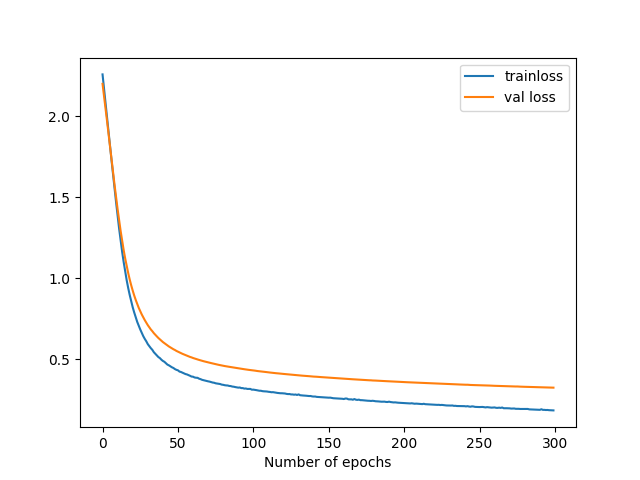

******* [7 2 1 ... 0 0 0] [7 2 1 ... 0 0 0]
confusion matrix


<IPython.core.display.Javascript object>


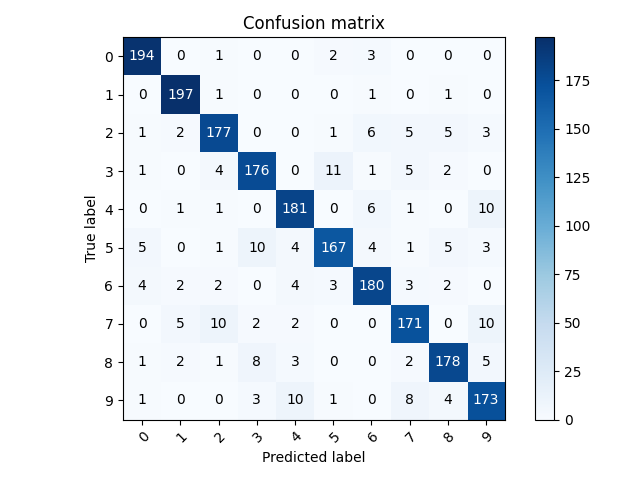

accuracy 0.897
saving weights.....


<IPython.core.display.Javascript object>


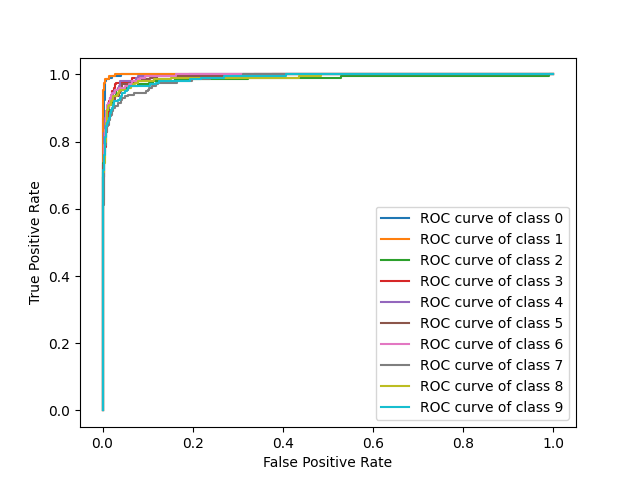

830.4993653297424


In [ ]:
classifier.val_X = val_X.reshape(-1,784)/255.0
classifier.val_y = val_Y_one_hot
import time
start =time.time()
classifier.fit((train_X.reshape(-1,784)/255.0),train_Y_one_hot)
print(time.time()-start)

In [ ]:
import joblib
classifier.weights = joblib.load('weight_relu_he_64_lr_0001')
classifier.biases = joblib.load('bias_relu_he_64_lr_0001')

In [ ]:
classifier.predict(val_X.reshape(-1,784))

array([7, 2, 1, ..., 0, 0, 0])

In [ ]:
accuracy_score(classifier.predict(val_X.reshape(-1,784)),val_y)

0.898

In [ ]:
classifier.predict_proba(val_X.reshape(-1,784))

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
classifier.score(val_X.reshape(-1,784),val_y)

0.898

## sigmoid activation batch size 64 (300 epochs) lr=0.001 (xavier initialization)

In [ ]:
classifier = MLPClassifier([784,128,64,10],batch_size=64,learning_rate=0.001,num_epochs=300,activation_function='sigmoid',Weight_init='xavier')

epoch:  0   epoch training loss 2.377390319973095
epoch:  0   epoch validation loss 2.353160911457673
validation accuracy 0.1
epoch:  1   epoch training loss 2.348094533684824
epoch:  1   epoch validation loss 2.3320397729538103
validation accuracy 0.1
epoch:  2   epoch training loss 2.3299902989321675
epoch:  2   epoch validation loss 2.3187401103529224
validation accuracy 0.1
epoch:  3   epoch training loss 2.3181481240182027
epoch:  3   epoch validation loss 2.3104666691277154
validation accuracy 0.104
epoch:  4   epoch training loss 2.3110823674511916
epoch:  4   epoch validation loss 2.3052500110195906
validation accuracy 0.114
epoch:  5   epoch training loss 2.3057214546926508
epoch:  5   epoch validation loss 2.302056893921227
validation accuracy 0.116
epoch:  6   epoch training loss 2.3030754888789597
epoch:  6   epoch validation loss 2.299984393814765
validation accuracy 0.128
epoch:  7   epoch training loss 2.300702089609143
epoch:  7   epoch validation loss 2.298774631602814

epoch:  63   epoch training loss 2.2707857359160424
epoch:  63   epoch validation loss 2.273139841772059
validation accuracy 0.5555
epoch:  64   epoch training loss 2.2701218502167877
epoch:  64   epoch validation loss 2.272584554631029
validation accuracy 0.5555
epoch:  65   epoch training loss 2.269543514177418
epoch:  65   epoch validation loss 2.2720469122166596
validation accuracy 0.5595
epoch:  66   epoch training loss 2.2688883495617307
epoch:  66   epoch validation loss 2.2714675869046235
validation accuracy 0.5625
epoch:  67   epoch training loss 2.2683586371018927
epoch:  67   epoch validation loss 2.2708974367571404
validation accuracy 0.5615
epoch:  68   epoch training loss 2.267723133416983
epoch:  68   epoch validation loss 2.270333265204555
validation accuracy 0.553
epoch:  69   epoch training loss 2.2671663535292974
epoch:  69   epoch validation loss 2.2697805930413417
validation accuracy 0.549
epoch:  70   epoch training loss 2.2665321748989706
epoch:  70   epoch valid

epoch:  125   epoch validation loss 2.2277371846159553
validation accuracy 0.5745
epoch:  126   epoch training loss 2.2196516420278427
epoch:  126   epoch validation loss 2.226695490579647
validation accuracy 0.5745
epoch:  127   epoch training loss 2.2185284498003535
epoch:  127   epoch validation loss 2.2256407057992473
validation accuracy 0.572
epoch:  128   epoch training loss 2.217348960476534
epoch:  128   epoch validation loss 2.224545304647677
validation accuracy 0.5745
epoch:  129   epoch training loss 2.2160428149544495
epoch:  129   epoch validation loss 2.223409774481317
validation accuracy 0.5715
epoch:  130   epoch training loss 2.2151172037407303
epoch:  130   epoch validation loss 2.2223557197160497
validation accuracy 0.57
epoch:  131   epoch training loss 2.2137559407668244
epoch:  131   epoch validation loss 2.2212571831540613
validation accuracy 0.5625
epoch:  132   epoch training loss 2.212519082091513
epoch:  132   epoch validation loss 2.2201796053035974
validati

epoch:  187   epoch training loss 2.109878311540551
epoch:  187   epoch validation loss 2.1256648946378043
validation accuracy 0.5545
epoch:  188   epoch training loss 2.1071685567462834
epoch:  188   epoch validation loss 2.1231445421909436
validation accuracy 0.557
epoch:  189   epoch training loss 2.104572663985994
epoch:  189   epoch validation loss 2.1205313780515165
validation accuracy 0.5555
epoch:  190   epoch training loss 2.1017618070760657
epoch:  190   epoch validation loss 2.117933361826976
validation accuracy 0.5545
epoch:  191   epoch training loss 2.0990397432155135
epoch:  191   epoch validation loss 2.1153785571796817
validation accuracy 0.5555
epoch:  192   epoch training loss 2.0960344773605364
epoch:  192   epoch validation loss 2.1127209056354768
validation accuracy 0.5565
epoch:  193   epoch training loss 2.0931989207845922
epoch:  193   epoch validation loss 2.110055845106494
validation accuracy 0.5565
epoch:  194   epoch training loss 2.090422615691779
epoch:  

epoch:  248   epoch validation loss 1.9020400740727021
validation accuracy 0.5585
epoch:  249   epoch training loss 1.865125795768833
epoch:  249   epoch validation loss 1.8972975830093222
validation accuracy 0.5575
epoch:  250   epoch training loss 1.860100846104874
epoch:  250   epoch validation loss 1.8925079230107045
validation accuracy 0.56
epoch:  251   epoch training loss 1.8549945143754145
epoch:  251   epoch validation loss 1.8877008139974327
validation accuracy 0.56
epoch:  252   epoch training loss 1.8500168122330214
epoch:  252   epoch validation loss 1.8829155916199283
validation accuracy 0.56
epoch:  253   epoch training loss 1.8451840145895635
epoch:  253   epoch validation loss 1.8780713264900102
validation accuracy 0.5615
epoch:  254   epoch training loss 1.839665217076493
epoch:  254   epoch validation loss 1.8731788456037053
validation accuracy 0.5615
epoch:  255   epoch training loss 1.8350049828651631
epoch:  255   epoch validation loss 1.8683040582999482
validatio

<IPython.core.display.Javascript object>


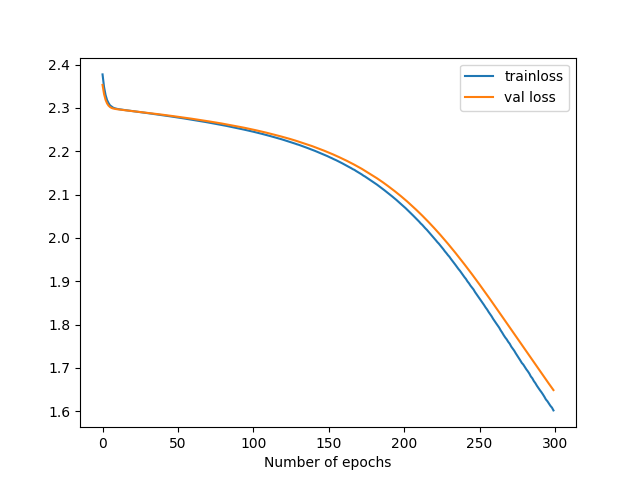

******* [7 2 1 ... 0 0 0] [7 2 1 ... 0 0 0]
confusion matrix


<IPython.core.display.Javascript object>


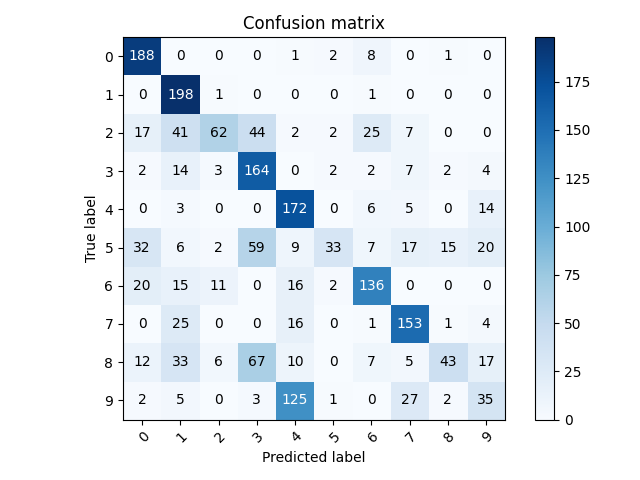

accuracy 0.592
saving weights.....


<IPython.core.display.Javascript object>


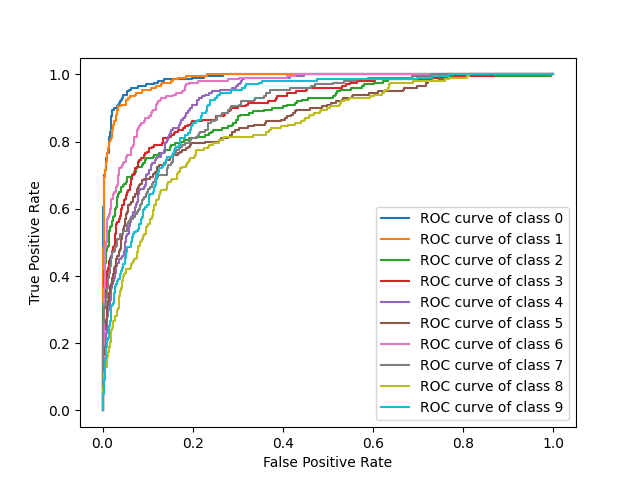

947.800048828125


In [ ]:
classifier.val_X = val_X.reshape(-1,784)/255.0
classifier.val_y = val_Y_one_hot
import time
start =time.time()
classifier.fit((train_X.reshape(-1,784)/255.0),train_Y_one_hot)
print(time.time()-start)

In [ ]:
classifier.weights = joblib.load('weight_sigmoid_xavier_64_lr_0001')
classifier.biases = joblib.load('bias_sigmoid_xavier_64_lr_0001')

In [ ]:
classifier.score(val_X.reshape(-1,784)/255.0,val_y)

0.5835

## sigmoid activation batch size 64 (300 epochs) lr=0.001 He initialization

In [ ]:
classifier = MLPClassifier([784,128,64,10],batch_size=64,learning_rate=0.001,num_epochs=300,activation_function='sigmoid',Weight_init='he')

epoch:  0   epoch training loss 2.4400329240081144
epoch:  0   epoch validation loss 2.3978993832466986
validation accuracy 0.1
epoch:  1   epoch training loss 2.3854768697866864
epoch:  1   epoch validation loss 2.3579577758148327
validation accuracy 0.1045
epoch:  2   epoch training loss 2.3512789487753913
epoch:  2   epoch validation loss 2.3322974964976364
validation accuracy 0.1135
epoch:  3   epoch training loss 2.328655227616267
epoch:  3   epoch validation loss 2.315731372266146
validation accuracy 0.12
epoch:  4   epoch training loss 2.3144146233776657
epoch:  4   epoch validation loss 2.304841733372752
validation accuracy 0.1305
epoch:  5   epoch training loss 2.3038130504662746
epoch:  5   epoch validation loss 2.2978349036982335
validation accuracy 0.152
epoch:  6   epoch training loss 2.297841514737711
epoch:  6   epoch validation loss 2.293041418132358
validation accuracy 0.1625
epoch:  7   epoch training loss 2.292803235444545
epoch:  7   epoch validation loss 2.28989329

epoch:  63   epoch training loss 2.1847872134551953
epoch:  63   epoch validation loss 2.1939048403790675
validation accuracy 0.579
epoch:  64   epoch training loss 2.182147020008185
epoch:  64   epoch validation loss 2.1917258593015503
validation accuracy 0.577
epoch:  65   epoch training loss 2.179791398814213
epoch:  65   epoch validation loss 2.18954589935354
validation accuracy 0.5775
epoch:  66   epoch training loss 2.1771325994303874
epoch:  66   epoch validation loss 2.187291941618538
validation accuracy 0.5815
epoch:  67   epoch training loss 2.174874843327781
epoch:  67   epoch validation loss 2.185033025658083
validation accuracy 0.5795
epoch:  68   epoch training loss 2.1723451043860824
epoch:  68   epoch validation loss 2.182756909430076
validation accuracy 0.5745
epoch:  69   epoch training loss 2.1700273008046285
epoch:  69   epoch validation loss 2.1804741208407976
validation accuracy 0.5755
epoch:  70   epoch training loss 2.1674111071110227
epoch:  70   epoch validati

epoch:  125   epoch training loss 1.9690838647229547
epoch:  125   epoch validation loss 1.9959740503648176
validation accuracy 0.5965
epoch:  126   epoch training loss 1.9641914111977683
epoch:  126   epoch validation loss 1.9914585251474999
validation accuracy 0.596
epoch:  127   epoch training loss 1.9593491498232298
epoch:  127   epoch validation loss 1.9868978320989643
validation accuracy 0.595
epoch:  128   epoch training loss 1.9544082059614305
epoch:  128   epoch validation loss 1.9822684181782293
validation accuracy 0.596
epoch:  129   epoch training loss 1.9489150018734707
epoch:  129   epoch validation loss 1.9775516700868043
validation accuracy 0.595
epoch:  130   epoch training loss 1.9448919595872616
epoch:  130   epoch validation loss 1.9729123960330457
validation accuracy 0.596
epoch:  131   epoch training loss 1.9391689135671861
epoch:  131   epoch validation loss 1.9681991923968067
validation accuracy 0.596
epoch:  132   epoch training loss 1.934016650448793
epoch:  1

epoch:  186   epoch validation loss 1.661864531773428
validation accuracy 0.628
epoch:  187   epoch training loss 1.6053187974422976
epoch:  187   epoch validation loss 1.6560017103594071
validation accuracy 0.627
epoch:  188   epoch training loss 1.599254035338543
epoch:  188   epoch validation loss 1.6501239654740159
validation accuracy 0.63
epoch:  189   epoch training loss 1.5933900115539799
epoch:  189   epoch validation loss 1.6441655967315536
validation accuracy 0.6305
epoch:  190   epoch training loss 1.5873070456622813
epoch:  190   epoch validation loss 1.6383129701960306
validation accuracy 0.6315
epoch:  191   epoch training loss 1.5810413368947025
epoch:  191   epoch validation loss 1.6325520246204737
validation accuracy 0.6335
epoch:  192   epoch training loss 1.5746940415412833
epoch:  192   epoch validation loss 1.6267319499579445
validation accuracy 0.6345
epoch:  193   epoch training loss 1.5684667323629637
epoch:  193   epoch validation loss 1.6209345548314755
valida

epoch:  248   epoch training loss 1.2658531815013034
epoch:  248   epoch validation loss 1.3354235312899139
validation accuracy 0.683
epoch:  249   epoch training loss 1.2614674332094855
epoch:  249   epoch validation loss 1.3309837687546726
validation accuracy 0.6845
epoch:  250   epoch training loss 1.256946619593271
epoch:  250   epoch validation loss 1.3265269024676292
validation accuracy 0.685
epoch:  251   epoch training loss 1.2522125537691766
epoch:  251   epoch validation loss 1.3221249321760324
validation accuracy 0.686
epoch:  252   epoch training loss 1.2478603026149122
epoch:  252   epoch validation loss 1.3177725009713424
validation accuracy 0.6875
epoch:  253   epoch training loss 1.2431924940001593
epoch:  253   epoch validation loss 1.3133945285590294
validation accuracy 0.6875
epoch:  254   epoch training loss 1.238350178423176
epoch:  254   epoch validation loss 1.3090012722568252
validation accuracy 0.689
epoch:  255   epoch training loss 1.2350753254942235
epoch:  

<IPython.core.display.Javascript object>


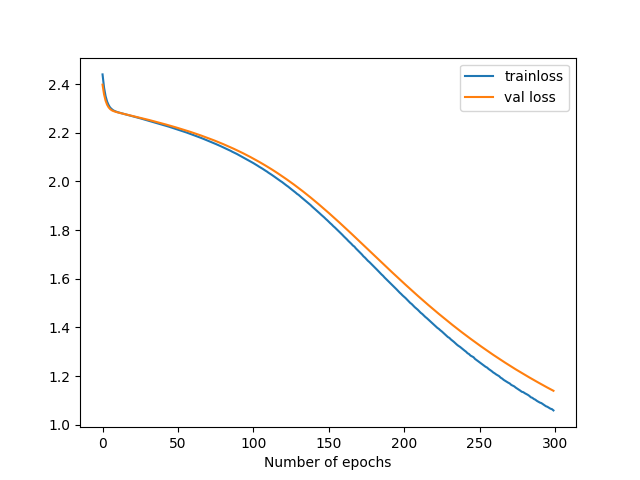

******* [7 2 1 ... 0 0 0] [7 2 1 ... 0 0 0]
confusion matrix


<IPython.core.display.Javascript object>


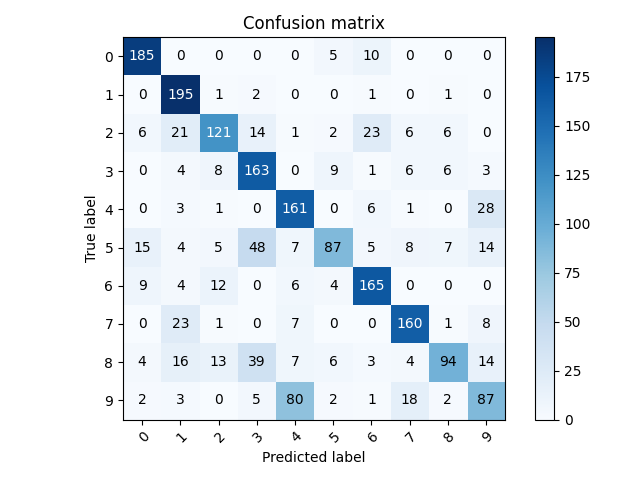

accuracy 0.709
saving weights.....


<IPython.core.display.Javascript object>


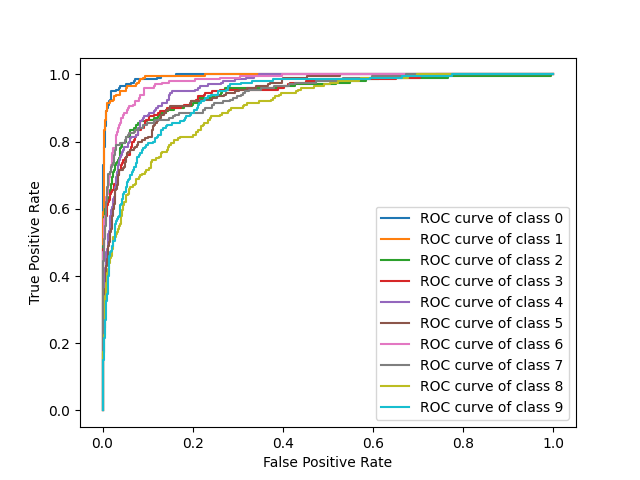

1041.013803243637


In [ ]:
classifier.val_X = val_X.reshape(-1,784)/255.0
classifier.val_y = val_Y_one_hot
import time
start =time.time()
classifier.fit((train_X.reshape(-1,784)/255.0),train_Y_one_hot)
print(time.time()-start)

In [ ]:
classifier.weights = joblib.load('weight_sigmoid_he_64_lr_0001')
classifier.biases = joblib.load('bias_sigmoid_he_64_lr_0001')

In [ ]:
classifier.score(val_X.reshape(-1,784)/255.0,val_y)

0.709

In [ ]:
classifier = MLPClassifier([784,128,64,10],batch_size=64,learning_rate=0.01,num_epochs=300,activation_function='tanh', Weight_init='xavier')

epoch:  0   epoch training loss 1.8839139542350292
epoch:  0   epoch validation loss 1.5782508238021875
validation accuracy 0.669
epoch:  1   epoch training loss 1.2588444601472926
epoch:  1   epoch validation loss 1.1444118996965653
validation accuracy 0.749
epoch:  2   epoch training loss 0.9159594855906812
epoch:  2   epoch validation loss 0.9112987028858341
validation accuracy 0.7855
epoch:  3   epoch training loss 0.7319198202441415
epoch:  3   epoch validation loss 0.7763075296804056
validation accuracy 0.8155
epoch:  4   epoch training loss 0.6213771046006386
epoch:  4   epoch validation loss 0.6889797832917696
validation accuracy 0.8355
epoch:  5   epoch training loss 0.5479252399245299
epoch:  5   epoch validation loss 0.6302089284585278
validation accuracy 0.843
epoch:  6   epoch training loss 0.4960131819811406
epoch:  6   epoch validation loss 0.5873808385144316
validation accuracy 0.8475
epoch:  7   epoch training loss 0.458697432796334
epoch:  7   epoch validation loss 0.

epoch:  62   epoch training loss 0.17422345315468604
epoch:  62   epoch validation loss 0.3245517947033973
validation accuracy 0.901
epoch:  63   epoch training loss 0.17310379741306411
epoch:  63   epoch validation loss 0.3242339987622471
validation accuracy 0.8955
epoch:  64   epoch training loss 0.16970911930642749
epoch:  64   epoch validation loss 0.3210457109384618
validation accuracy 0.901
epoch:  65   epoch training loss 0.1677061795740332
epoch:  65   epoch validation loss 0.31942876829176864
validation accuracy 0.9015
epoch:  66   epoch training loss 0.16539524183022886
epoch:  66   epoch validation loss 0.31893483814759854
validation accuracy 0.903
epoch:  67   epoch training loss 0.16368634997507087
epoch:  67   epoch validation loss 0.3174955804184742
validation accuracy 0.9015
epoch:  68   epoch training loss 0.16215525923615245
epoch:  68   epoch validation loss 0.3164162526846432
validation accuracy 0.903
epoch:  69   epoch training loss 0.16038890637640266
epoch:  69  

epoch:  123   epoch validation loss 0.27070217437885374
validation accuracy 0.917
epoch:  124   epoch training loss 0.09028201431815112
epoch:  124   epoch validation loss 0.26989635564257397
validation accuracy 0.916
epoch:  125   epoch training loss 0.08877398101293789
epoch:  125   epoch validation loss 0.27040224840242455
validation accuracy 0.917
epoch:  126   epoch training loss 0.08802490745467448
epoch:  126   epoch validation loss 0.2701840800279804
validation accuracy 0.917
epoch:  127   epoch training loss 0.0872093306018733
epoch:  127   epoch validation loss 0.2696421491106565
validation accuracy 0.917
epoch:  128   epoch training loss 0.0886467490147049
epoch:  128   epoch validation loss 0.2704232383769
validation accuracy 0.9165
epoch:  129   epoch training loss 0.08551403451547032
epoch:  129   epoch validation loss 0.26819498785018203
validation accuracy 0.9165
epoch:  130   epoch training loss 0.08728998961392333
epoch:  130   epoch validation loss 0.2673281464039218

epoch:  184   epoch training loss 0.04894102559912345
epoch:  184   epoch validation loss 0.2527930344748155
validation accuracy 0.926
epoch:  185   epoch training loss 0.04847189406435972
epoch:  185   epoch validation loss 0.25198197405595313
validation accuracy 0.9255
epoch:  186   epoch training loss 0.048230783334411
epoch:  186   epoch validation loss 0.25182460748778174
validation accuracy 0.926
epoch:  187   epoch training loss 0.04812776201109282
epoch:  187   epoch validation loss 0.2525829224396565
validation accuracy 0.925
epoch:  188   epoch training loss 0.047233718348963526
epoch:  188   epoch validation loss 0.2511269828675948
validation accuracy 0.9285
epoch:  189   epoch training loss 0.04670172605730878
epoch:  189   epoch validation loss 0.2515690269599792
validation accuracy 0.927
epoch:  190   epoch training loss 0.047204277322255475
epoch:  190   epoch validation loss 0.2510500962236664
validation accuracy 0.926
epoch:  191   epoch training loss 0.046414336668909

epoch:  244   epoch validation loss 0.24542976196682587
validation accuracy 0.9275
epoch:  245   epoch training loss 0.028100367743728327
epoch:  245   epoch validation loss 0.24483943245756426
validation accuracy 0.9325
epoch:  246   epoch training loss 0.0275934915701487
epoch:  246   epoch validation loss 0.24508614447620877
validation accuracy 0.9285
epoch:  247   epoch training loss 0.02724200022451396
epoch:  247   epoch validation loss 0.24557152009898103
validation accuracy 0.9285
epoch:  248   epoch training loss 0.026949772518412504
epoch:  248   epoch validation loss 0.24557584941014657
validation accuracy 0.93
epoch:  249   epoch training loss 0.026692184201019677
epoch:  249   epoch validation loss 0.24510992830858835
validation accuracy 0.9315
epoch:  250   epoch training loss 0.026426598493724498
epoch:  250   epoch validation loss 0.24513943001355437
validation accuracy 0.9295
epoch:  251   epoch training loss 0.02631177072635807
epoch:  251   epoch validation loss 0.24

<IPython.core.display.Javascript object>


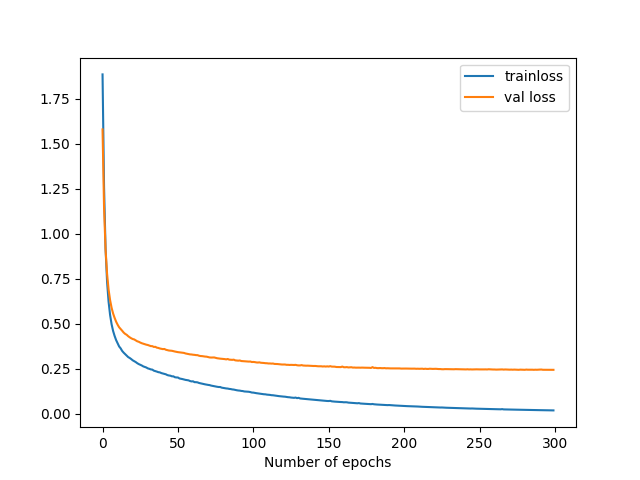

******* [7 2 1 ... 0 0 0] [7 2 1 ... 0 0 0]
confusion matrix


<IPython.core.display.Javascript object>


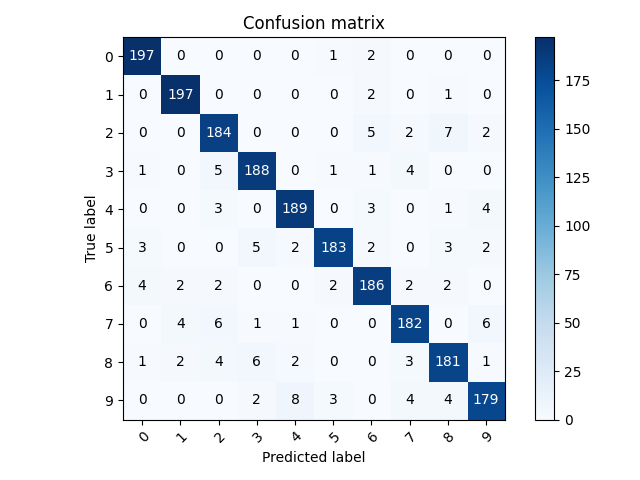

accuracy 0.933
saving weights.....


<IPython.core.display.Javascript object>


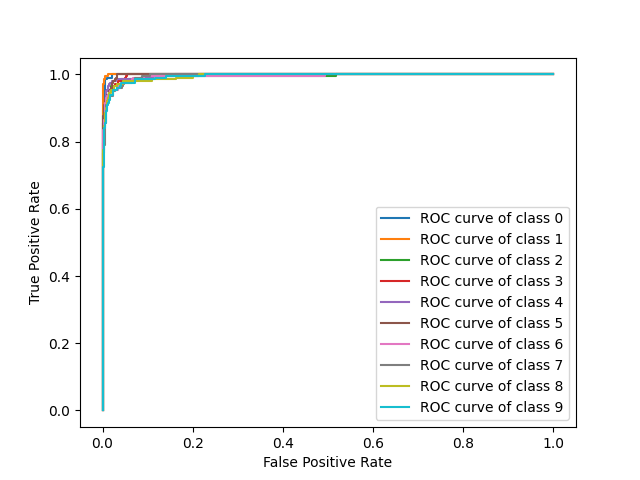

1015.7334129810333


In [ ]:
classifier.val_X = val_X.reshape(-1,784)/255.0
classifier.val_y = val_Y_one_hot
import time
start =time.time()
classifier.fit((train_X.reshape(-1,784)/255.0),train_Y_one_hot)
print(time.time()-start)

In [ ]:
classifier.weights = joblib.load('weight_tanh_xavier_64_lr_001')
classifier.biases = joblib.load('bias_tanh_xavier_64_lr_001')

In [ ]:
classifier.score(val_X.reshape(-1,784)/255.0,val_y)

0.933

## tanh activation batch size 64 (300 epochs) lr=0.01 he


In [ ]:
classifier = MLPClassifier([784,128,64,10],batch_size=64,learning_rate=0.01,num_epochs=300,activation_function='tanh', Weight_init='he')

epoch:  0   epoch training loss 1.5033198550479685
epoch:  0   epoch validation loss 1.1347961983911368
validation accuracy 0.744
epoch:  1   epoch training loss 0.8566294607927155
epoch:  1   epoch validation loss 0.8469044189003129
validation accuracy 0.799
epoch:  2   epoch training loss 0.6524185440127325
epoch:  2   epoch validation loss 0.7106028098933205
validation accuracy 0.8195
epoch:  3   epoch training loss 0.5517015486902803
epoch:  3   epoch validation loss 0.6337663322664635
validation accuracy 0.838
epoch:  4   epoch training loss 0.4904966524646865
epoch:  4   epoch validation loss 0.5831419950815496
validation accuracy 0.845
epoch:  5   epoch training loss 0.44846005978840797
epoch:  5   epoch validation loss 0.5490571373524618
validation accuracy 0.853
epoch:  6   epoch training loss 0.41677798239090275
epoch:  6   epoch validation loss 0.5218967275446371
validation accuracy 0.856
epoch:  7   epoch training loss 0.39382312727588786
epoch:  7   epoch validation loss 0

epoch:  62   epoch training loss 0.15025758156462377
epoch:  62   epoch validation loss 0.3061223442261071
validation accuracy 0.9085
epoch:  63   epoch training loss 0.1488376678871342
epoch:  63   epoch validation loss 0.3052468621056386
validation accuracy 0.904
epoch:  64   epoch training loss 0.1459947144141165
epoch:  64   epoch validation loss 0.30236531796929655
validation accuracy 0.9075
epoch:  65   epoch training loss 0.1441294407368822
epoch:  65   epoch validation loss 0.30094588812203743
validation accuracy 0.908
epoch:  66   epoch training loss 0.14193802653775667
epoch:  66   epoch validation loss 0.3006030224627576
validation accuracy 0.9075
epoch:  67   epoch training loss 0.14030625625741033
epoch:  67   epoch validation loss 0.29898012669614826
validation accuracy 0.9095
epoch:  68   epoch training loss 0.1388957593187745
epoch:  68   epoch validation loss 0.29810912172181614
validation accuracy 0.909
epoch:  69   epoch training loss 0.1371665158278208
epoch:  69   

epoch:  123   epoch training loss 0.07444052857573685
epoch:  123   epoch validation loss 0.2599113725157641
validation accuracy 0.918
epoch:  124   epoch training loss 0.07390868138087527
epoch:  124   epoch validation loss 0.25889791758885344
validation accuracy 0.918
epoch:  125   epoch training loss 0.07267057267441915
epoch:  125   epoch validation loss 0.25986126226232276
validation accuracy 0.9175
epoch:  126   epoch training loss 0.0719863108939686
epoch:  126   epoch validation loss 0.25966526357474967
validation accuracy 0.9185
epoch:  127   epoch training loss 0.07129348138021423
epoch:  127   epoch validation loss 0.25929489767216846
validation accuracy 0.9195
epoch:  128   epoch training loss 0.07232100178838424
epoch:  128   epoch validation loss 0.2610669014217127
validation accuracy 0.9205
epoch:  129   epoch training loss 0.06985290758270421
epoch:  129   epoch validation loss 0.2580871143464915
validation accuracy 0.9185
epoch:  130   epoch training loss 0.07139840742

epoch:  183   epoch validation loss 0.2441966570787198
validation accuracy 0.924
epoch:  184   epoch training loss 0.03901659690035213
epoch:  184   epoch validation loss 0.24452019350684231
validation accuracy 0.925
epoch:  185   epoch training loss 0.03861941327442309
epoch:  185   epoch validation loss 0.24364064186059092
validation accuracy 0.926
epoch:  186   epoch training loss 0.038435234581220244
epoch:  186   epoch validation loss 0.24333943002792205
validation accuracy 0.924
epoch:  187   epoch training loss 0.03825535952571653
epoch:  187   epoch validation loss 0.24394633304043734
validation accuracy 0.924
epoch:  188   epoch training loss 0.03760622696894142
epoch:  188   epoch validation loss 0.24276457864583795
validation accuracy 0.925
epoch:  189   epoch training loss 0.03720397978760034
epoch:  189   epoch validation loss 0.2433747013427118
validation accuracy 0.9255
epoch:  190   epoch training loss 0.03719598572175917
epoch:  190   epoch validation loss 0.2427982420

epoch:  244   epoch training loss 0.02222230414475451
epoch:  244   epoch validation loss 0.23792576545353297
validation accuracy 0.9285
epoch:  245   epoch training loss 0.022374527423675687
epoch:  245   epoch validation loss 0.2378791181415095
validation accuracy 0.9315
epoch:  246   epoch training loss 0.022047930544441277
epoch:  246   epoch validation loss 0.23760773346420616
validation accuracy 0.9275
epoch:  247   epoch training loss 0.02172447291862972
epoch:  247   epoch validation loss 0.23836158461782153
validation accuracy 0.929
epoch:  248   epoch training loss 0.021541141565733824
epoch:  248   epoch validation loss 0.2384544667638095
validation accuracy 0.9285
epoch:  249   epoch training loss 0.021333834109591127
epoch:  249   epoch validation loss 0.23794850114182703
validation accuracy 0.9295
epoch:  250   epoch training loss 0.021156504980894213
epoch:  250   epoch validation loss 0.23771770078103133
validation accuracy 0.9285
epoch:  251   epoch training loss 0.021

<IPython.core.display.Javascript object>


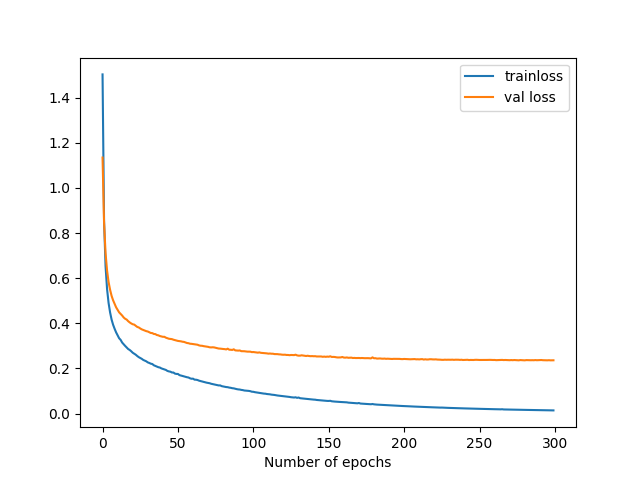

******* [7 2 1 ... 0 0 0] [7 2 1 ... 0 0 0]
confusion matrix


<IPython.core.display.Javascript object>


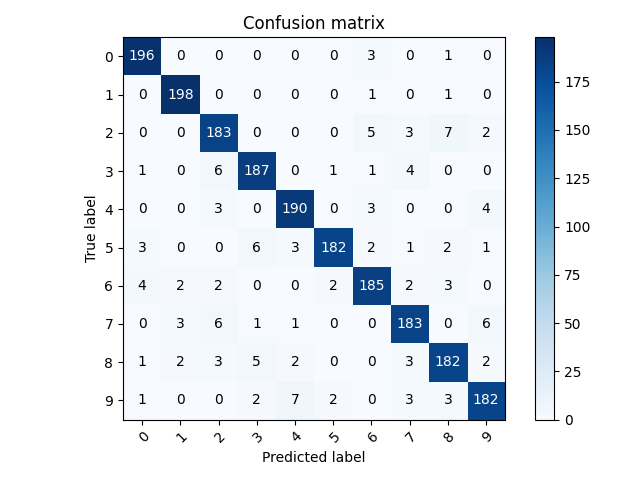

accuracy 0.934
saving weights.....


<IPython.core.display.Javascript object>


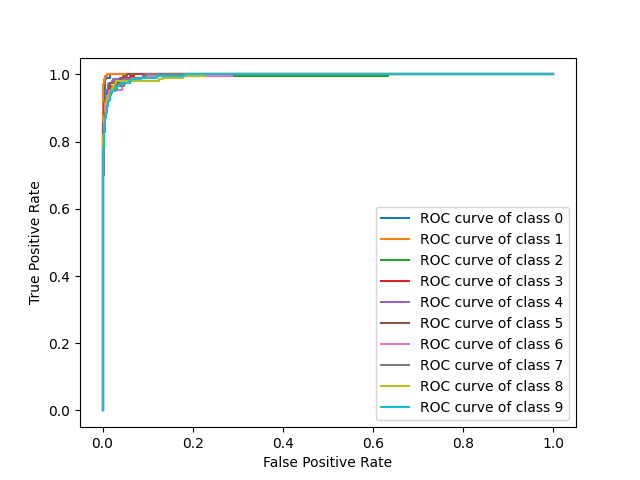

1065.712172985077


In [ ]:
classifier.val_X = val_X.reshape(-1,784)/255.0
classifier.val_y = val_Y_one_hot
import time
start =time.time()
classifier.fit((train_X.reshape(-1,784)/255.0),train_Y_one_hot)
print(time.time()-start)

In [ ]:
import joblib
classifier.weights = joblib.load('weight_tanh_he_64_lr_001')
classifier.biases = joblib.load('bias_tanh_he_64_lr_001')

In [ ]:
classifier.score(val_X.reshape(-1,784)/255.0,val_y)

0.934